In [10]:
import torch
import torchaudio
import os
import glob
import IPython.display as ipd
import pandas as pd

LABELS_DIR = 'labels'
WAV_DIR = 'audio/parts'
FADE_SAMPLES = 1000

In [11]:
wavs = sorted(glob.glob(os.path.join(WAV_DIR, '*.wav')))

In [12]:
def read_wav_filtered(
        wav_file,
        label_file,
        fade_samples = FADE_SAMPLES,
    ):
    # TODO: Remove when used in DataLoader
    global label_dfs

    # Can be taken out of the function and passed in as an argument
    fade_in = torch.sigmoid(torch.linspace(-5, 5, fade_samples))
    fade_out = torch.sigmoid(torch.linspace(5, -5, fade_samples))

    waveform, sample_rate = torchaudio.load(wav_file)
    label_df = pd.read_csv(label_file, dtype={
        'Start [s]': float,
        'End [s]': float,
        'Speaker': str
    })

    label_df['Start'] = (label_df['Start [s]'] * sample_rate).astype(int).clip(0, waveform.shape[1])
    label_df['End'] = (label_df['End [s]'] * sample_rate).astype(int).clip(0, waveform.shape[1])

    # TODO: Remove when used in DataLoader
    label_dfs.append(label_df)

 
    mask = torch.empty_like(waveform, dtype=torch.bool)
    mask[:, :] = True
    
    for start_idx, end_index in zip(label_df['Start'], label_df['End']):
        fade_in_end_idx = max(0, min(start_idx + fade_samples, waveform.shape[1]))
        fade_in_samples = fade_in_end_idx - start_idx
        fade_out_start_idx = max(0, min(end_index - fade_samples, waveform.shape[1]))
        fade_out_samples = end_index - fade_out_start_idx
        waveform[:, start_idx:fade_in_end_idx] *= fade_in[fade_in.shape[0] - fade_in_samples:]
        mask[:, fade_in_end_idx:fade_out_start_idx] = False
        waveform[:, fade_out_start_idx:end_index] *= fade_out[:-fade_out_samples+1]
    
    return waveform[mask], sample_rate

In [18]:
filtered_wavs = []
loaded_wavs = []
label_dfs = []

for wav in wavs:
    # Get the matching label file
    label_file = os.path.join(LABELS_DIR, f'{os.path.basename(wav).split('.')[0]}_unwanted.csv')

    # Needed only to show examples layer in notebook
    # Don't load the file twice in actual DataLoader
    waveform, sample_rate = torchaudio.load(wav)
    filtered_waveform, _ = read_wav_filtered(wav, label_file)

    filtered_wavs.append((filtered_waveform, sample_rate))
    

Show the dataframe with unwanted speakers. 

In [14]:
idx = 32
label_dfs[idx]

,Start [s],End [s],Speaker,Start,End
0,3.658744,4.439728,SPEAKER_01,58539,71035
1,6.544992,10.466893,SPEAKER_01,104719,167470
2,10.993209,14.151104,SPEAKER_01,175891,226417


Play the original audio.

In [15]:
waveform, sample_rate = loaded_wavs[idx]
ipd.display(ipd.Audio(waveform, rate=sample_rate))

Play the filtered audio.

In [16]:
waveform, sample_rate = filtered_wavs[idx]
ipd.display(ipd.Audio(waveform, rate=sample_rate))

Visualize the `fade_in` and `fade_out` curves applied to mute unwanted speakers.

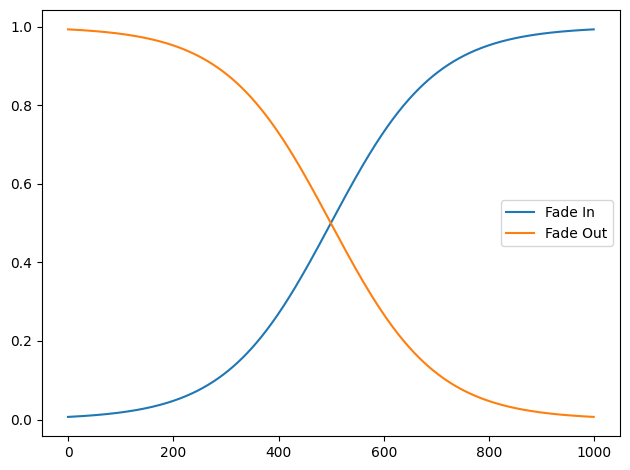

In [17]:
import matplotlib.pyplot as plt

fade_in = torch.sigmoid(torch.linspace(-5, 5, FADE_SAMPLES))
fade_out = torch.sigmoid(torch.linspace(5, -5, FADE_SAMPLES))

plt.plot(fade_in, label='Fade In')
plt.plot(fade_out, label='Fade Out')
plt.legend()
plt.tight_layout()